In [1]:
from __future__ import print_function
import numpy as np
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from collections import Counter
import time

import matplotlib.pyplot as plt
import sklearn
from sklearn import tree

In [2]:
#scikit learn classifier with train values
def scikit_learn(train):
    y = train[train.columns[-1]].values.tolist()
    x = train[train.columns[:-1]].values.tolist()
    clf = sklearn.tree.DecisionTreeClassifier()
    clf.fit(x,y)
    return clf
    

In [3]:
#Prediction of scikit-learn on a given row. 
def scikit_predict(clf,test):
    x_test = test[test.columns[:-1]].values.tolist()
    y_test = test[test.columns[-1]].values.tolist()
    cnt = 0
    accurate = 0
    for index,row in enumerate(x_test):
        cnt+=1
        test = clf.predict([row])
        if(test[0]==y_test[index]): 
            accurate+=1
    return 1.0*accurate/cnt
        
    

In [4]:
#Count of each row in the dataset. 
def class_counts(dataset):
    
    last_name = dataset.columns[-1]  
    last_col = dataset[last_name]
    counter = Counter(last_col) 
    return counter
    

In [5]:

def most_frequent(counter): 
    maxi = 0
    ele = 0
    for i in counter.keys():
        if(counter[i]>maxi):
            ele = i
            maxi = counter[i]
    return ele

In [6]:
def gini(rows):

    
    classes = class_counts(rows)
    
    total=len(rows)
    p=0
    for i in classes:
        p+= (classes[i]*1.0 / total)**2
        
        
        
    return 1-p

In [7]:
def info_gain(upper, lower, current):
    upper_len = len(upper)
    lower_len = len(lower)
    p = lower_len*1.0 / (lower_len + upper_len)
    
    s = p * gini(lower) + (1 - p) * gini(upper)
    gain = current - s
    
    return gain

In [8]:
class Output: 
    def __init__(self,rows):
        self.prediction = most_frequent(class_counts(rows))
    
        
   

In [9]:
class Decision_Node:
    
    def __init__(self,cutoff,attr,true,false): 
        self.true = true
        self.false = false
        self.attr = attr
        self.cutoff = cutoff

In [10]:
def best_split(dataset): 
    best_gain = -10
    best_attr = 0 
    best_cutoff = 0
    
    current = gini(dataset)
    
    features = dataset.columns[:-1]
    
    for attr in features:
        cutoff = set(dataset[attr])
        for cut in cutoff:
            upper,lower = part(dataset,cut,attr)
            if(len(upper)==0 or len(lower)==0): 
                continue
           
            gain = info_gain(upper,lower,current)
            if(gain>best_gain): 
                best_gain = gain
                best_attr = attr
                best_cutoff = cut
        
    return best_gain, best_attr, best_cutoff
            
            


In [11]:
def part(dataset,cutoff,attr):
    
    upper = dataset[dataset[attr]>cutoff]
    lower = dataset[dataset[attr]<=cutoff]
    
    return upper,lower
    

In [12]:
def build_tree(dataset,depth,greedy): 
    
    best_gain, best_attr,best_cutoff = best_split(dataset)
    if greedy:
        if(best_gain<=0):
            return Output(dataset)
    else: 
        if(depth==0 or len(dataset)<5): 
            return Output(dataset)
    
    upper,lower = part(dataset,best_cutoff,best_attr)
    
    true_branch = build_tree(upper,depth-1,greedy)
    false_branch = build_tree(lower,depth-1,greedy)
    
    return Decision_Node(best_cutoff,best_attr,true_branch,false_branch)
        

In [13]:
#Check a given row for the condition.
def check(row,node):
    at = node.attr
    
    if(row[at]>node.cutoff):
        return True
    else:
        return False


In [14]:
#A classification for iris datase
def classify_iris(row,node):
    if isinstance(node,Output): 
        return node.prediction
    else: 
        if(check(row,node)):
            return classify_iris(row,node.true)
        else:
            return classify_iris(row,node.false)
    

In [15]:
#Dividing the data into train and test.
def divide_data(dataset):
    attr = dataset.columns
    train = []
    test = []
    for index,row in dataset.iterrows():
        if(index%3==0):
            test.append(row)
        else: 
            train.append(row)
    return pd.DataFrame(train),pd.DataFrame(test)
    

In [16]:
#Evaluating on the test set
def accuracy(test,tree):
    accurate = 0
    cnt = 0
    listed = test.values.tolist()
    for index,row in test.iterrows(): 
        cnt+=1
        if(row.tolist()[-1]==classify_iris(row,tree)):
            accurate+=1
    return 1.0*accurate/cnt
    

In [18]:
#Q2(a)Creating the Decision tree.

dataset = pd.read_csv('iris.csv')
my_tree = build_tree(dataset,3,True)

In [19]:
#Q2(b) Checking the accuracy on iris dataset 66% training and 33% testing. 
#Building tree using greedy
train,test = divide_data(dataset)
tree_1 = build_tree(train,2,True) 
accuracy_1 = accuracy(test,tree_1)
print("My accuracy is",accuracy_1)


My accuracy is 0.9


In [20]:
#Q2(c) 5 fold cross validation on Iris dataset. 

def cross_valid(total_data,greedy=False):
    max_acc = 0
    opt_depth = 0
    for depth in range(1,5):
        
        train_data = total_data[:120]
        test_data = total_data[120:150]
        tree1 = build_tree(train_data,depth,greedy)
        accuracy1 = accuracy(test_data,tree1)

        train_data = total_data[30:150]
        test_data = total_data[0:30]
        tree2 = build_tree(train_data,depth,greedy)
        accuracy2 = accuracy(test_data,tree2)

        test_data = total_data[30:60]
        train_data = pd.concat([total_data[:30],total_data[60:150]])
        tree3 = build_tree(train_data,depth,greedy)
        accuracy3 = accuracy(test_data,tree3)

        test_data = total_data[60:90]
        train_data = pd.concat([total_data[:60],total_data[90:150]])
        tree4 = build_tree(train_data,depth,greedy)
        accuracy4 = accuracy(test_data,tree4)

        test_data = total_data[90:120]
        train_data = pd.concat([total_data[:90],total_data[120:150]])
        tree5 = build_tree(train_data,depth,greedy)
        accuracy5 = accuracy(test_data,tree5)
        
        avg_acc = (accuracy1+accuracy2+accuracy3+accuracy4+accuracy5)/5.
        
        if(avg_acc>max_acc):
            max_acc = avg_acc
            opt_depth = depth
        
    
    
    return max_acc,opt_depth 


In [21]:
#Q2(c) Cross validation on dataset.

acc = cross_valid(dataset)


print("the accuracy of tree is", acc[0])
print("the optimal tree height",acc[1])



the accuracy of tree is 0.9200000000000002
the optimal tree height 2


In [22]:
#Q4. Comparing classifier with scikit-learn.

train,test = divide_data(dataset)

built_tree = build_tree(train,3,False)

my_accuracy = accuracy(test,built_tree)

clf = scikit_learn(train)

scikit_accuracy = scikit_predict(clf, test)

print("my accuracy is",my_accuracy)
print("scikit accuracy is",scikit_accuracy)

my accuracy is 0.92
scikit accuracy is 0.86


In [23]:
#Q5 displaying the tree. This has been done with a simple print function instead of dtreeviz. 

def show_tree(node,space = ""): 
    if isinstance(node,Output): 
        print(space+"output is", node.prediction) 
        return
    
    print (space+str(node.attr)+'>'+str(node.cutoff))
    
    print(space+'--->True')
    
    show_tree(node.true,space+"    ")
    
    print(space+'--->False')
    
    show_tree(node.false,space+"    ")
    
    
    

In [24]:
show_tree(my_tree)

petal_length>1.9
--->True
    petal_width>1.7
    --->True
        petal_length>4.8
        --->True
            output is virginica
        --->False
            sepal_length>5.9
            --->True
                output is virginica
            --->False
                output is versicolor
    --->False
        petal_length>4.9
        --->True
            petal_width>1.5
            --->True
                sepal_length>6.7
                --->True
                    output is virginica
                --->False
                    output is versicolor
            --->False
                output is virginica
        --->False
            petal_width>1.6
            --->True
                output is virginica
            --->False
                output is versicolor
--->False
    output is setosa


In [25]:
#Q6. The IRIS data classification problem. 
#finding the best possible order of implementation 
built_tree = build_tree(train,1,False)
my_accuracy = accuracy(train,built_tree)
print("the accuracy of size 1 tree ",my_accuracy)

built_tree = build_tree(train,2,False)
my_accuracy = accuracy(train,built_tree)
print("the accuracy of size 2 tree",my_accuracy)

built_tree = build_tree(train,3,False)
my_accuracy = accuracy(train,built_tree)
print("the accuracy of size 3 tree",my_accuracy)

built_tree = build_tree(train,4,False)
my_accuracy = accuracy(train,built_tree)
print("the accuracy of size 4 tree",my_accuracy)

built_tree = build_tree(train,5,False)
my_accuracy = accuracy(train, built_tree) 

built_tree = build_tree(train,1,True)
my_accuracy = accuracy(train, built_tree)

#After exhaustive enumeration we observe that tree depth of 1 gives worst output.

#The best possible value is 1 and worst possible is 4. 
#The greedy order gives an accuracy of 1.0

#Now comparing performance on test set.
built_tree = build_tree(train,1,True)
my_accuracy = accuracy(test,built_tree)
print("greedy accuracy",my_accuracy)

built_tree = build_tree(train,4,False)
my_accuracy = accuracy(test,built_tree)
print("best order",my_accuracy)

built_tree = build_tree(train,1,False)
my_accuracy = accuracy(test,built_tree)
print("worst order",my_accuracy)



the accuracy of size 1 tree  0.67
the accuracy of size 2 tree 0.96
the accuracy of size 3 tree 0.97
the accuracy of size 4 tree 0.99
greedy accuracy 0.9
best order 0.9
worst order 0.66


<Figure size 432x288 with 0 Axes>

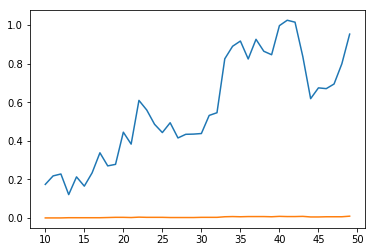

In [27]:
#Q7 Creating fake data for experiments and finding time complexity of algorithm
##For constant N and variable m. 

start_m,end_m = 10,50
start_n,end_n = 10,50

fig1 = plt.figure()
fig2 = plt.figure()
depth = 2

#Keeping n constant. n = 10
time_train = []
time_test = []
#Variation with m.
for i in range(start_m,end_m):
        j = 10
        
        arr = np.random.randint(2, size=(i,j))
        
        data_train = pd.DataFrame(arr)
        
        start_train = time.time()
        
        built_tree = build_tree(data_train,depth,True)
        
        end_train = time.time()
        
        start_test = time.time() 
        
        acc = accuracy(data_train,built_tree)
        
        end_test = time.time() 
        
        time_train.append([end_train - start_train])
        time_test.append([end_test-start_test])
        
        

        
       
           
x_train = range(start_m,end_m)
x_test = range(start_n, end_n)
y_train = time_train
y_test = time_test

plt.plot(x_train,y_train) 
plt.plot(x_test,y_test)


<Figure size 432x288 with 0 Axes>

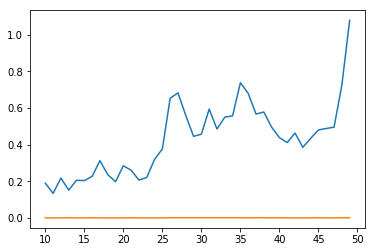

In [28]:
#Q7 Creating fake data for experiments and finding time complexity of algorithm
##For constant M  and variable N 

start_n,end_n = 10,50
start_m,end_m = 10,50

fig1 = plt.figure()
fig2 = plt.figure()
depth = 2


time_train = []
time_test = []

for j in range(start_n,end_n):
        i = 10
        
        arr = np.random.randint(2, size=(i,j))
        
        data_train = pd.DataFrame(arr)
        
        start_train = time.time()
        
        built_tree = build_tree(data_train,depth,True)
        
        end_train = time.time()
        
        start_test = time.time() 
        
        acc = accuracy(data_train,built_tree)
        
        end_test = time.time() 
        
        time_train.append([end_train - start_train])
        time_test.append([end_test-start_test])
        
        

        
       
           
x_train = range(start_m,end_m)
x_test = range(start_n, end_n)
y_train = time_train
y_test = time_test

plt.plot(x_train,y_train) 
plt.plot(x_test,y_test)


ModuleNotFoundError: No module named 'defs'